### 필요 정보 불러오기

In [31]:
import json

def load_config():
    with open('./config.json', 'r', encoding='utf-8') as f:
        config = json.load(f)
    
    username = config['login']['username']
    password = config['login']['password']
    keywords = config['keywords']
    iter = config['iter']
    
    return username, password, keywords, iter

### URL 수집

In [53]:
import os
import time
from datetime import datetime
import pytz
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
import urllib
import re
import shutil

user_id, password, keywords, iter = load_config()
driver = webdriver.Chrome()

# 한국 표준시 설정
kst = pytz.timezone('Asia/Seoul')
current_time = datetime.now(kst)
current_datetime = current_time.strftime("%Y%m%d_%H%M%S")

csv_path = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/urls/url.csv' # 기존에 저장되어 있던 url
new_csv_path = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/urls/new_url_{}.csv'.format(current_datetime) # 이번에 새로 모이는 데이터들

# 기존 CSV 파일이 없으면 새로 생성
if not os.path.exists(csv_path):
    df = pd.DataFrame(columns=['keyword', 'url', 'full_text'])
    df.to_csv(csv_path, index=False, encoding='utf-8')
    print(f'새로운 CSV 파일 생성: {csv_path}')
    
if not os.path.exists(new_csv_path):
    df = pd.DataFrame(columns=['keyword', 'url', 'full_text'])
    df.to_csv(new_csv_path, index=False, encoding='utf-8')
    print(f'새로운 CSV 파일 생성: {new_csv_path}')
    
# 백업 파일 하나 생성
back_up = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/urls/url_backup.csv'
shutil.copyfile(csv_path, back_up)
    
Data_List = []  # 데이터 저장 리스트

# Instagram 접속 및 로그인
url = 'https://www.instagram.com/'
driver.get(url)
time.sleep(6)
user = driver.find_element(By.XPATH, '//*[@id="loginForm"]/div/div[1]/div/label/input')
user.send_keys(user_id)
driver.find_element(By.XPATH, '//*[@id="loginForm"]/div/div[2]/div/label/input').send_keys(password)
driver.find_element(By.XPATH, '//*[@id="loginForm"]/div/div[3]/button/div').click()
time.sleep(80)

index = 0  # 키워드 인덱스
dup_count = 0  # 총 중복 개수

while index < len(keywords):
    word = keywords[index]
    print(word)

    if not word:
        print('키워드가 비어 있습니다!')
        index += 1
        continue
    
    word = urllib.parse.quote(word)
    word_url = f'https://www.instagram.com/explore/tags/{word}/'
    driver.get(word_url)

    key_dup_count = 0
    try:
        page = 0
        for y in range(iter):  # 크롤링 반복 횟수 설정
            time.sleep(5)
            js = 'window.scrollBy(0,1000)'
            driver.execute_script(js)
            html = driver.page_source
            soup = BeautifulSoup(html, 'lxml')

            divimg = soup.find_all('img', {'class': 'x5yr21d xu96u03 x10l6tqk x13vifvy x87ps6o xh8yej3'})
            if not divimg:
                print('이미지를 찾을 수 없습니다.')
                continue

            for div in divimg:
                content = div.get('alt')
                if not content:
                    print('내용이 없습니다.')
                    continue

                data = []
                a = div.find_parent('a')
                if a is None:
                    print('게시물 링크가 잘못되었습니다.')
                    continue
                urlto = a.get('href')
                if urlto is None:
                    print('게시물 링크가 없습니다.')
                    continue
                totalurl = 'https://www.instagram.com' + urlto
                data.append(keywords[index])
                data.append(totalurl)
                
                modified_content = re.sub(r'\s*\n\s*', ' ', content)
                data.append(modified_content)

                Data_List.append(data)
                
            page += 1
            print(f'페이지 {page}에서 데이터를 가져오는 중...')
            time.sleep(5)

    except Exception as e:
        print(e)
        print('오류 발생')
        
    print(f'키워드 {keywords[index]}의 URL 정보 수집 완료.')

    # 중복 제거
    Data_List_New = []
    for data in Data_List:
        if data not in Data_List_New:
            Data_List_New.append(data)
        else:
            key_dup_count += 1

    print(f'키워드 {keywords[index]}에서 {key_dup_count} 개의 중복 제거 후, 총 {len(Data_List_New)} 개의 데이터 크롤링 완료!')
    df_Sheet = pd.DataFrame(Data_List_New, columns=['keyword', 'url', 'full_text'])
    
    df = pd.read_csv(csv_path, encoding='utf-8', usecols=['keyword', 'url', 'full_text'])
    unique_df = pd.read_csv(new_csv_path, encoding='utf-8', usecols=['keyword', 'url', 'full_text'])
    
    file = [df, df_Sheet]
    new_df = pd.concat(file, axis=0)
    
    uniq_data = df_Sheet.merge(df, on=['keyword', 'url', 'full_text'], how='left', indicator=True)
    uniq_data = uniq_data[uniq_data['_merge'] == 'left_only'].drop(columns='_merge')
    uniq_file = [unique_df, uniq_data]
    new_uniq_df = pd.concat(uniq_file, axis=0)
    
    # 전체 URL CSV 갱신
    final_df = new_df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)
    final_df.to_csv(csv_path, index=False, encoding='utf-8')
    
    # 새로운 URL CSV 갱신
    final_uniq_df = new_uniq_df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)
    final_uniq_df.to_csv(new_csv_path, index=False, encoding='utf-8')
    
    index += 1
    dup_count += key_dup_count

driver.close()

# 최종 중복 제거 및 저장
Data_List_New = []
for data in Data_List:
    if data not in Data_List_New:
        Data_List_New.append(data)
    else:
        dup_count += 1

print('-------------------------------------')
print(f'{dup_count} 개의 중복 제거 후, 총 {len(Data_List_New)} 개의 새로운 데이터를 크롤링했습니다.')
df_Sheet = pd.DataFrame(Data_List_New, columns=['keyword', 'url', 'full_text'])
df = pd.read_csv(csv_path, encoding='utf-8', usecols=['keyword', 'url', 'full_text'])
unique_df = pd.read_csv(new_csv_path, encoding='utf-8', usecols=['keyword', 'url', 'full_text'])

file = [df, df_Sheet]
new_df = pd.concat(file, axis=0)

uniq_data = df_Sheet.merge(df, on=['keyword', 'url', 'full_text'], how='left', indicator=True)
uniq_data = uniq_data[uniq_data['_merge'] == 'left_only'].drop(columns='_merge')
uniq_file = [unique_df, uniq_data]
new_uniq_df = pd.concat(uniq_file, axis=0)

# 전체 URL CSV 갱신
final_df = new_df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)
final_df.to_csv(csv_path, index=False, encoding='utf-8')

# 새로운 URL CSV 갱신
final_uniq_df = new_uniq_df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)
final_uniq_df.to_csv(new_csv_path, index=False, encoding='utf-8')

새로운 CSV 파일 생성: /Users/baekkwanghyun/Desktop/Projects/5.Viral/urls/new_url_20240902_231907.csv
올리브영
페이지 1에서 데이터를 가져오는 중...
페이지 2에서 데이터를 가져오는 중...
페이지 3에서 데이터를 가져오는 중...
키워드 올리브영의 URL 정보 수집 완료.
키워드 올리브영에서 56 개의 중복 제거 후, 총 28 개의 데이터 크롤링 완료!
에스트라
페이지 1에서 데이터를 가져오는 중...
페이지 2에서 데이터를 가져오는 중...
페이지 3에서 데이터를 가져오는 중...
키워드 에스트라의 URL 정보 수집 완료.
키워드 에스트라에서 112 개의 중복 제거 후, 총 56 개의 데이터 크롤링 완료!
바이오더마
페이지 1에서 데이터를 가져오는 중...
페이지 2에서 데이터를 가져오는 중...
페이지 3에서 데이터를 가져오는 중...
키워드 바이오더마의 URL 정보 수집 완료.
키워드 바이오더마에서 168 개의 중복 제거 후, 총 84 개의 데이터 크롤링 완료!
-------------------------------------
504 개의 중복 제거 후, 총 84 개의 새로운 데이터를 크롤링했습니다.


### 데이터 수집

In [52]:
import os
import time
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
import requests
import re
import glob
import shutil

user_id, password, keywords, iter = load_config()
headers = {
    'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36'
}

# 최초에는 url 이 new_url 이기 때문에 new_url.csv 에 아무런 내용이 없으니, url.csv 로 데이터 수집 해야함.
#initial_csv = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/urls/url.csv'
folder_path = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/urls'
file_pattern = os.path.join(folder_path, 'new_url*.csv')
files = glob.glob(file_pattern)

if files:
    latest_file = max(files, key=os.path.getctime)
    print(f"최신 파일: {latest_file}")
else:
    print("해당 폴더에 'new_url'로 시작하는 파일이 없습니다.")

#urls = pd.read_csv(initial_csv, encoding='utf-8', usecols=['keyword', 'url', 'full_text'])
urls = pd.read_csv(latest_file, encoding='utf-8', usecols=['keyword', 'url', 'full_text'])


# 최종 데이터가 될 results
results = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/data.csv'
# 기존 CSV 파일이 없으면 새로 생성
if not os.path.exists(results):
    df = pd.DataFrame(columns=['brand', 'username', 'date', 'post_url', 'full_text', 'like', 'saved_imgs'])
    df.to_csv(results, index=False, encoding='utf-8')
    print(f'새로운 CSV 파일 생성: {results}')
    
data_df = pd.read_csv(results, encoding='utf-8', usecols=['brand', 'username', 'date', 'post_url', 'full_text', 'like', 'saved_imgs'])
    
# 백업 파일 하나 생성
back_up = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/data_backup.csv'
shutil.copyfile(results, back_up)

Data_List = [] # 데이터 저장 리스트
total_count = 0

# Instagram 접속 및 로그인
driver = webdriver.Chrome()

url = 'https://www.instagram.com/'
driver.get(url)
time.sleep(6)
user = driver.find_element(By.XPATH, '//*[@id="loginForm"]/div/div[1]/div/label/input')
user.send_keys(user_id)
driver.find_element(By.XPATH, '//*[@id="loginForm"]/div/div[2]/div/label/input').send_keys(password)
driver.find_element(By.XPATH, '//*[@id="loginForm"]/div/div[3]/button/div').click()
time.sleep(80)

for idx, row in urls.iterrows():

    brand, post_url, full_text = row
    
    if post_url in data_df['post_url'].values:
        continue
    
    data = []
    driver.get(post_url)
    print(idx, '. ' + post_url)

    try:
        time.sleep(5)
        html = driver.page_source
        soup = BeautifulSoup(html, 'lxml')
        
        # 작성자
        username = soup.find('span', {'class': '_ap3a _aaco _aacw _aacx _aad7 _aade'}).text
        print(username, end=' ')
        
        # 작성일자
        date = soup.find_all('time')[-1]['datetime'][:10]
        print(date, end=' ')
        
        # like 개수
        try:
            like = soup.find('span', {'class': 'html-span xdj266r x11i5rnm xat24cr x1mh8g0r xexx8yu x4uap5 x18d9i69 xkhd6sd x1hl2dhg x16tdsg8 x1vvkbs'}).text
        except Exception:
            like = 'no data' # ~~외 여러 명이 좋아합니다. 같은 경우
        print(like)
        
        # 이미지 저장
        images = []
        img_urls = set()
        images.append(driver.find_elements(By.CLASS_NAME, 'x5yr21d.xu96u03.x10l6tqk.x13vifvy.x87ps6o.xh8yej3'))
        
        for i in range(len(images)):
            for j in range(len(images[i])):
                
                if j >= 3: # 4번째부터 타 게시물의 썸네일 이미지
                    break
                
                alt = images[i][j].get_attribute('alt')
                check = re.findall(r'by .+? on', alt) # 타 게시물인지 아닌지 검사
                
                if check != []:
                    img_urls.add(images[i][j].get_attribute('src'))
        
        try:
            while True:
                time.sleep(3)
                
                driver.find_element(By.CLASS_NAME, '_afxw._al46._al47').click() # 다음 이미지 버튼 클릭
                images.append(driver.find_elements(By.CLASS_NAME, 'x5yr21d.xu96u03.x10l6tqk.x13vifvy.x87ps6o.xh8yej3'))
                
                for i in range(len(images)):
                    for j in range(len(images[i])):
                        
                        if j >= 3: # 4번째부터 타 게시물의 썸네일 이미지
                            break
                        
                        alt = images[i][j].get_attribute('alt')
                        check = re.findall(r'by .+? on', alt) # 타 게시물인지 아닌지 검사
                        
                        if check != []:
                            img_urls.add(images[i][j].get_attribute('src'))
                
                images.clear()
                
        except Exception:
            print('더 이상 넘길 이미지 없음')
            
            img_urls = list(img_urls)
            print(img_urls)
            images.clear()
        
        data.append(brand)
        data.append(username)
        data.append(date)
        data.append(post_url)
        data.append(full_text)
        data.append(like)
        
        saved_imgs = set()
        for img_url in img_urls:
            
            # 이미지만 고려. 우선 비디오 타입은 고려하지 않음.
            pattern = r'\/v\/[^\/]+\/([^\/\?]+)\.(jpg|png|webp|heic)'
            match = re.search(pattern, img_url)
            if match:
                img_name = match.group(1) + '.' + match.group(2)
            else:
                print('파일을 찾을 수 없거나 jpg 혹은 png, webp, heic 파일이 아님.')
                continue
            
            if img_name not in saved_imgs:
                response = requests.get(img_url, headers=headers, timeout=20)
                
                with open('/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/' + img_name, 'wb') as f:
                    f.write(response.content)
                
                saved_imgs.add(img_name)
                
            time.sleep(.5)
        
        print(f"총 {len(saved_imgs)} 장의 이미지 저장")
        data.append(str(list(saved_imgs)))
        
        Data_List.append(data)
        time.sleep(5)

    except Exception as e:
        print(e)
        print('오류 발생')
        
    
    if idx != 0 and idx % 10 == 0:
        Data_List_New = []
        for data in Data_List:
            if data not in Data_List_New:
                Data_List_New.append(data)
                
        print('-------------------------------------')
        print('{} 개의 데이터 크롤링 완료'.format(len(Data_List_New)))
        df_Sheet = pd.DataFrame(Data_List_New, columns=['brand', 'username', 'date', 'post_url', 'full_text', 'like', 'saved_imgs'])
        df = pd.read_csv(results, encoding='utf-8', usecols=['brand', 'username', 'date', 'post_url', 'full_text', 'like', 'saved_imgs'])
        file = [df, df_Sheet]
        new_df = pd.concat(file, axis=0)
        final_df = new_df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)
        final_df.to_csv(results, index=False, encoding='utf-8')
        
        Data_List.clear()
        time.sleep(10)

driver.close()

Data_List_New = []
for data in Data_List:
    if data not in Data_List_New:
        Data_List_New.append(data)

print('-------------------------------------')
print('총 {} 개의 데이터 크롤링 완료'.format(len(Data_List_New)))
df_Sheet = pd.DataFrame(Data_List_New, columns=['brand', 'username', 'date', 'post_url', 'full_text', 'like', 'saved_imgs'])
df = pd.read_csv(results, encoding='utf-8', usecols=['brand', 'username', 'date', 'post_url', 'full_text', 'like', 'saved_imgs'])
file = [df, df_Sheet]
new_df = pd.concat(file, axis=0)
final_df = new_df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)
final_df.to_csv(results, index=False, encoding='utf-8')

84 . https://www.instagram.com/p/C_aLgCOyA1W/
mukddoonge 2024-09-02 66
더 이상 넘길 이미지 없음
['https://scontent.cdninstagram.com/v/t51.29350-15/458181327_1987017445082990_1164683319531189982_n.webp?stp=dst-jpg_e35&efg=eyJ2ZW5jb2RlX3RhZyI6ImltYWdlX3VybGdlbi4xNDQweDE0NDAuc2RyLmYyOTM1MC5kZWZhdWx0X2ltYWdlIn0&_nc_ht=scontent.cdninstagram.com&_nc_cat=102&_nc_ohc=XXqsBdwss38Q7kNvgG8VQdy&edm=APs17CUBAAAA&ccb=7-5&ig_cache_key=MzQ0ODExOTAzNDMwOTY0MTQ5MA%3D%3D.2-ccb7-5&oh=00_AYAlKQvRzKxLT267IBQMrQrcW6nMlBQS3Cn_zt9f5DLXpA&oe=66DB7AF1&_nc_sid=10d13b']
총 1 장의 이미지 저장
85 . https://www.instagram.com/p/C_ak5_ayqDM/
minha_drama_diary 2024-09-02 54
더 이상 넘길 이미지 없음
['https://scontent.cdninstagram.com/v/t51.29350-15/457745740_386795110901898_8269175084334094495_n.webp?stp=dst-jpg_e35&efg=eyJ2ZW5jb2RlX3RhZyI6ImltYWdlX3VybGdlbi4xNDQweDE0NDAuc2RyLmYyOTM1MC5kZWZhdWx0X2ltYWdlIn0&_nc_ht=scontent.cdninstagram.com&_nc_cat=106&_nc_ohc=hB5tqqDV3KMQ7kNvgGp6MaM&_nc_gid=c6bee79ad9a54d259d61f02b54daed20&edm=APs17CUBAAAA&ccb=7-5&

### OCR 확인

##### Paddle OCR 활용

In [1]:
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image

ocr = PaddleOCR(use_angle_cls=False, lang='korean')

[2024/09/03 00:15:00] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/baekkwanghyun/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/baekkwanghyun/.paddleocr/whl/rec/korean/korean_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 

[2024/09/03 00:25:57] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/09/03 00:25:57] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.32410287857055664
[2024/09/03 00:26:03] ppocr DEBUG: rec_res num  : 37, elapsed : 6.4482550621032715


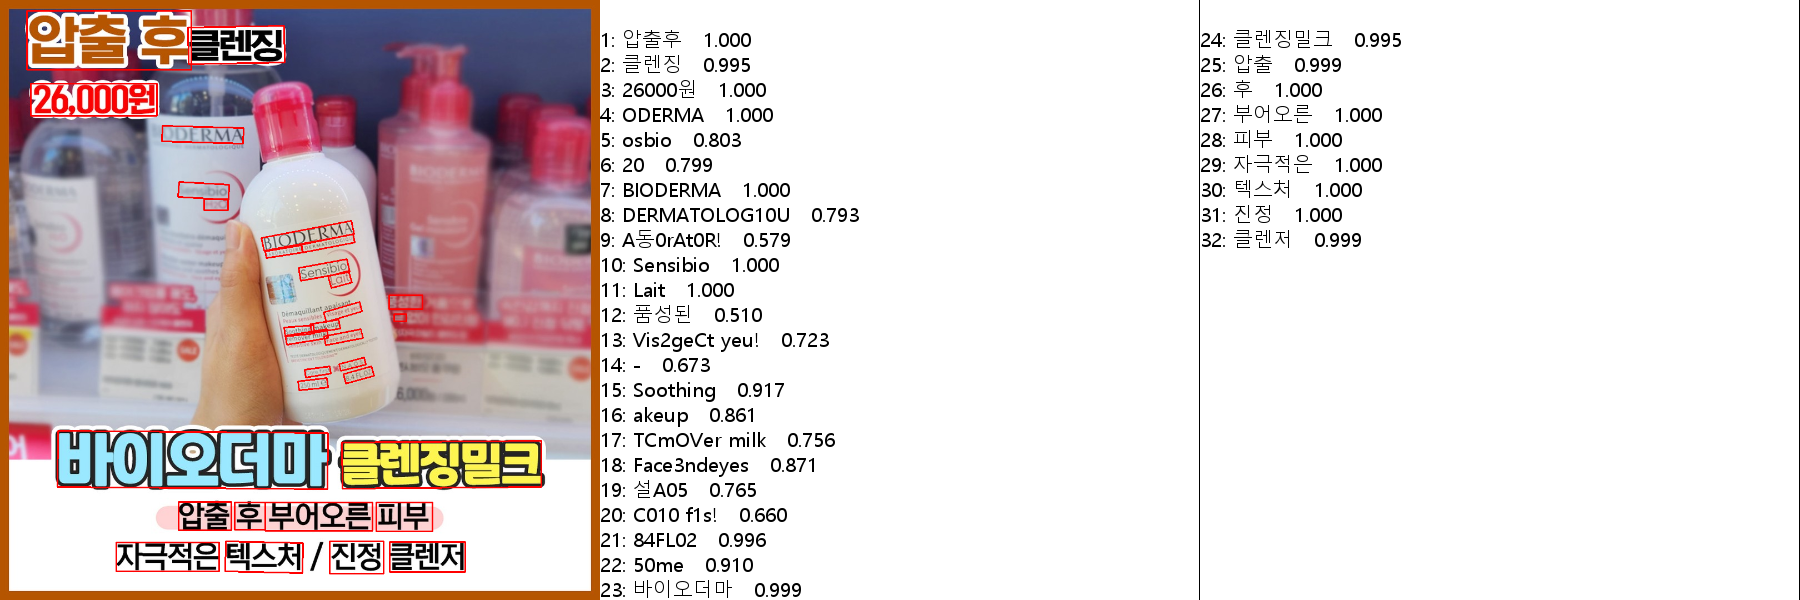

In [11]:
dir_path = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images'
img_path = dir_path + '/' + '312977254_506414844709396_8184524799963063546_n.jpg'

result = ocr.ocr(img_path, cls=True)

# for idx in range(len(result)):
#     res = result[idx]
#     for line in res:
#         print(line)

# draw result
result = result[0]
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(image, boxes, txts, scores, font_path='./fonts/malgun.ttf')
im_show = Image.fromarray(im_show)
im_show

[2024/09/03 00:25:48] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/09/03 00:25:48] ppocr DEBUG: dt_boxes num : 31, elapsed : 0.33013916015625
[2024/09/03 00:25:54] ppocr DEBUG: rec_res num  : 31, elapsed : 5.2240800857543945


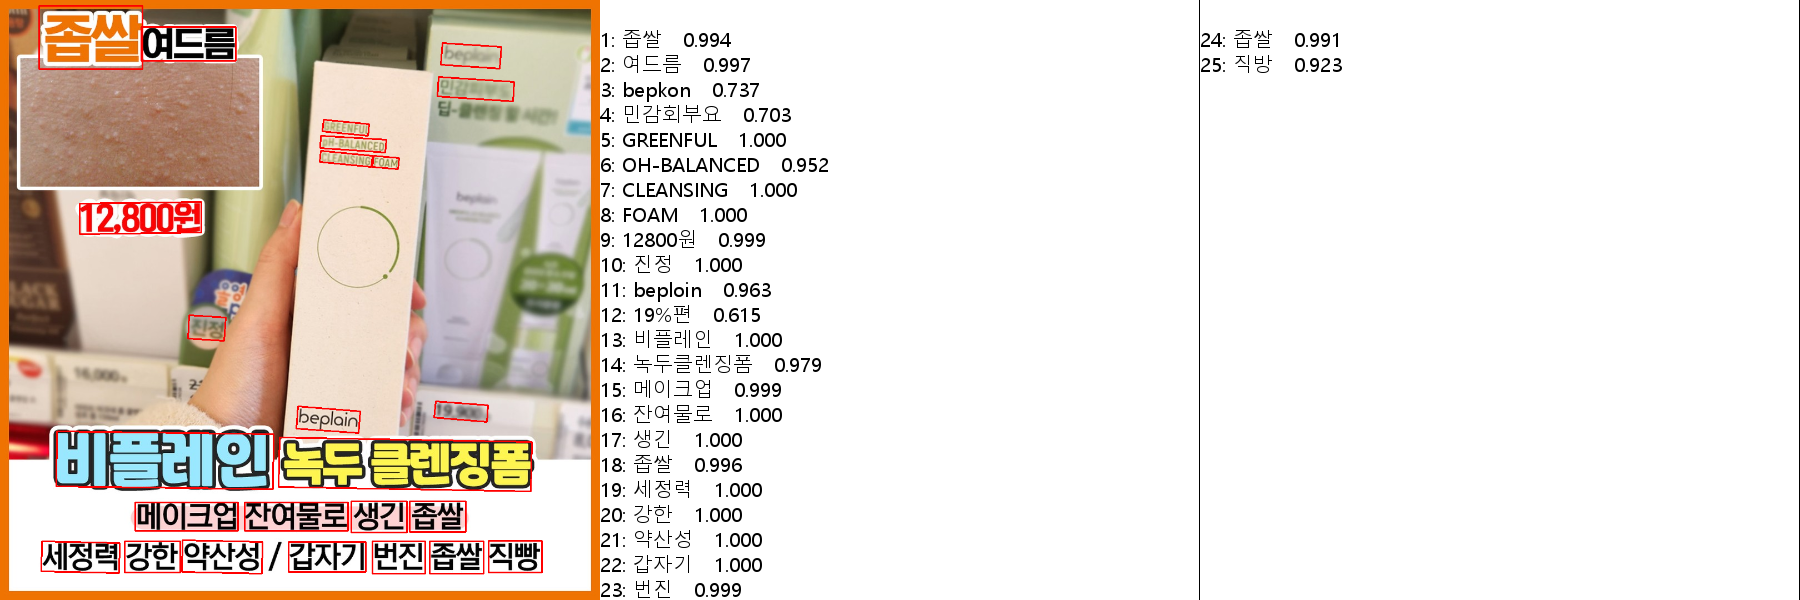

In [10]:
dir_path = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images'
img_path = dir_path + '/' + '313108873_111442341760748_1461606530793203724_n.jpg'

result = ocr.ocr(img_path, cls=True)

# for idx in range(len(result)):
#     res = result[idx]
#     for line in res:
#         print(line)

# draw result
result = result[0]
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(image, boxes, txts, scores, font_path='./fonts/malgun.ttf')
im_show = Image.fromarray(im_show)
im_show

[2024/09/03 00:27:28] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/09/03 00:27:28] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.3493680953979492
[2024/09/03 00:27:34] ppocr DEBUG: rec_res num  : 33, elapsed : 5.725895166397095


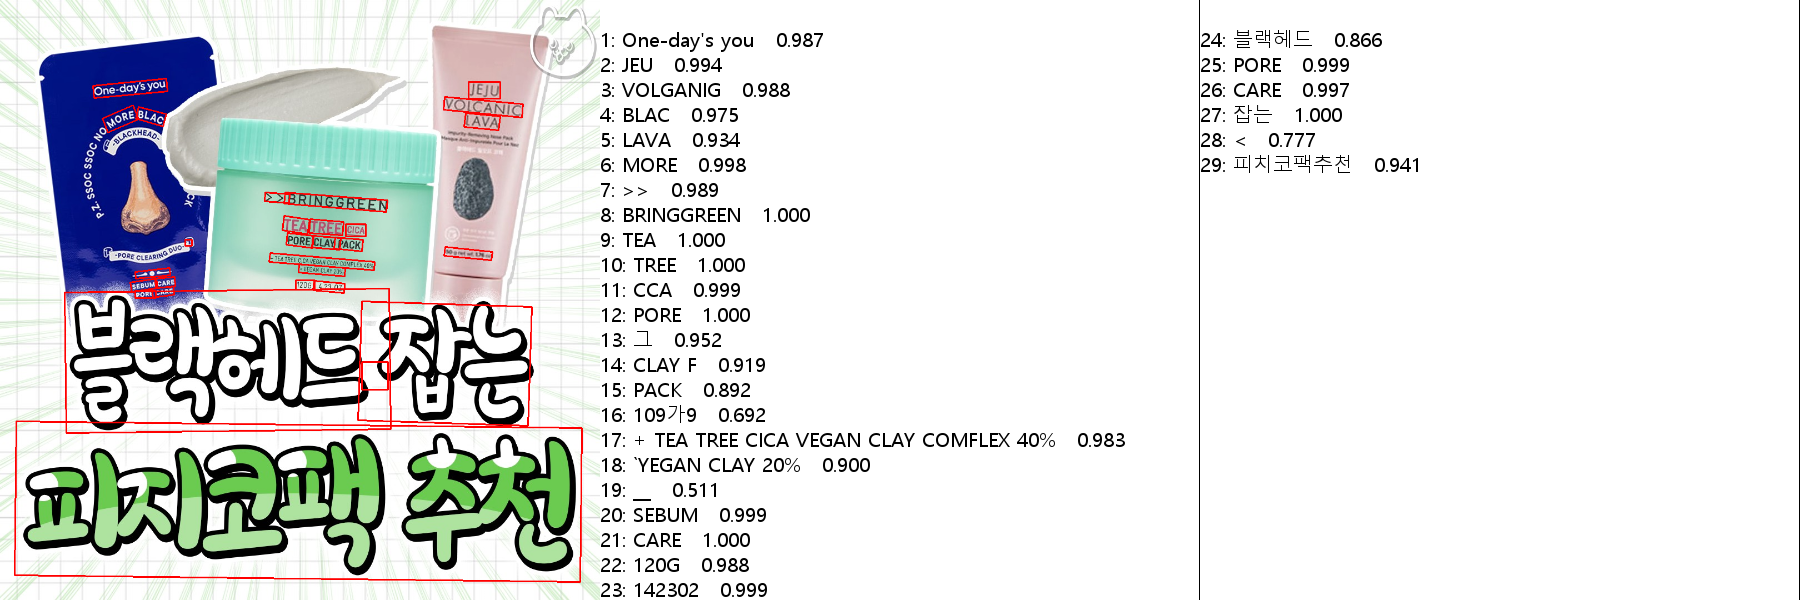

In [12]:
dir_path = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images'
img_path = dir_path + '/' + '457264328_821946053380928_1301868062921045026_n.jpg'

result = ocr.ocr(img_path, cls=True)

# for idx in range(len(result)):
#     res = result[idx]
#     for line in res:
#         print(line)

# draw result
result = result[0]
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(image, boxes, txts, scores, font_path='./fonts/malgun.ttf')
im_show = Image.fromarray(im_show)
im_show

[2024/09/03 00:27:50] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/09/03 00:27:50] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.2727060317993164
[2024/09/03 00:27:52] ppocr DEBUG: rec_res num  : 12, elapsed : 2.015329122543335


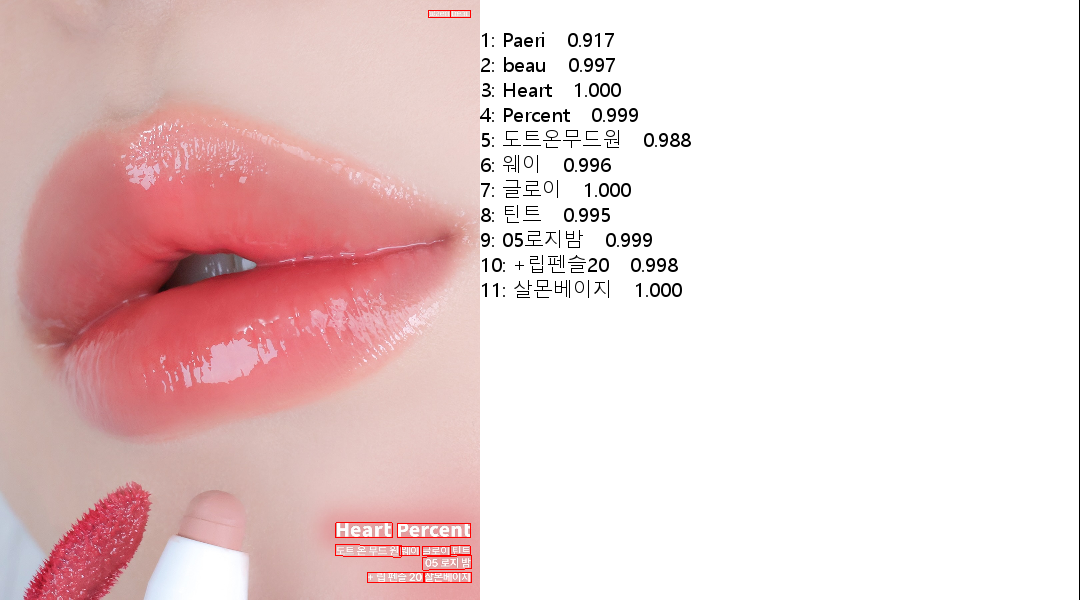

In [13]:
dir_path = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images'
img_path = dir_path + '/' + '458166281_1043477090665652_5306740415126840119_n.jpg'

result = ocr.ocr(img_path, cls=True)

# for idx in range(len(result)):
#     res = result[idx]
#     for line in res:
#         print(line)

# draw result
result = result[0]
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(image, boxes, txts, scores, font_path='./fonts/malgun.ttf')
im_show = Image.fromarray(im_show)
im_show

[2024/09/03 00:32:34] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/09/03 00:32:34] ppocr DEBUG: dt_boxes num : 23, elapsed : 0.303088903427124
[2024/09/03 00:32:38] ppocr DEBUG: rec_res num  : 23, elapsed : 3.876673936843872


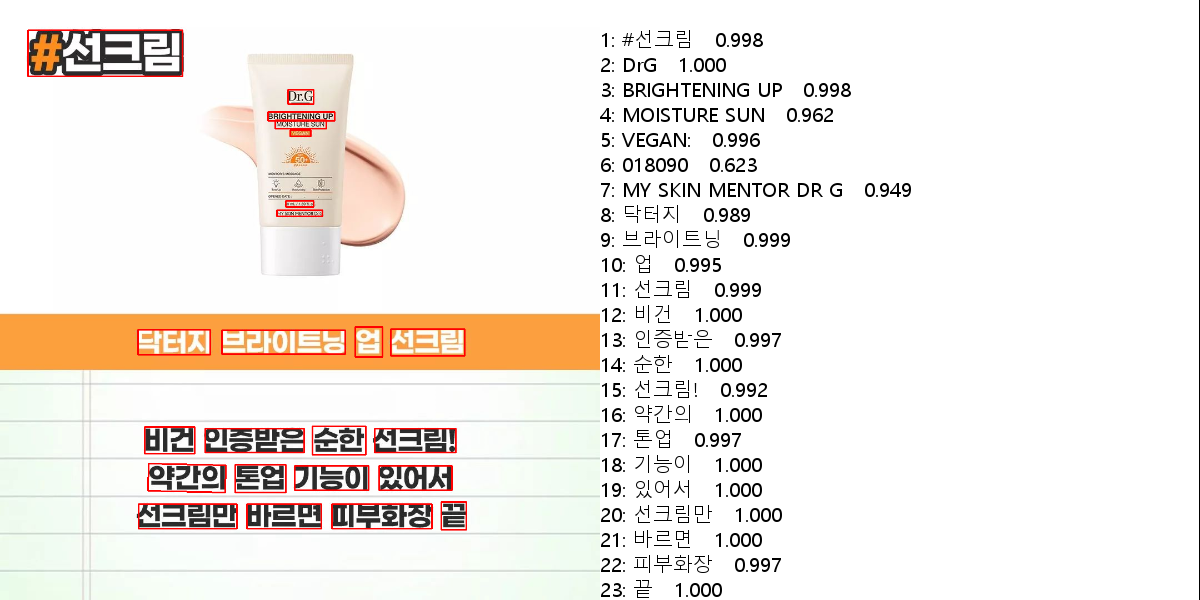

In [14]:
dir_path = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images'
img_path = dir_path + '/' + '458183516_1560596914830534_8219529635994072876_n.webp'

result = ocr.ocr(img_path, cls=True)

# for idx in range(len(result)):
#     res = result[idx]
#     for line in res:
#         print(line)

# draw result
result = result[0]
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(image, boxes, txts, scores, font_path='./fonts/malgun.ttf')
im_show = Image.fromarray(im_show)
im_show

[2024/09/03 01:08:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/09/03 01:08:06] ppocr DEBUG: dt_boxes num : 46, elapsed : 0.308272123336792
[2024/09/03 01:08:14] ppocr DEBUG: rec_res num  : 46, elapsed : 7.901318788528442
#블러셔 VEGAN FEEV BEAUTY FEEV VEGA7 FEEV WINNER FEEV FE타 FEEV FEEV 피브 컬러 세럼 가볍고 깨끗한 피부 메이크업 위에 파우더 블러셔 올리면 뭔가 급급하고 답답함 그럴 때 리퀴드 바르면 딱임!! 톤별로 있어서 원쿨 원하는거 사용하면 개꿀


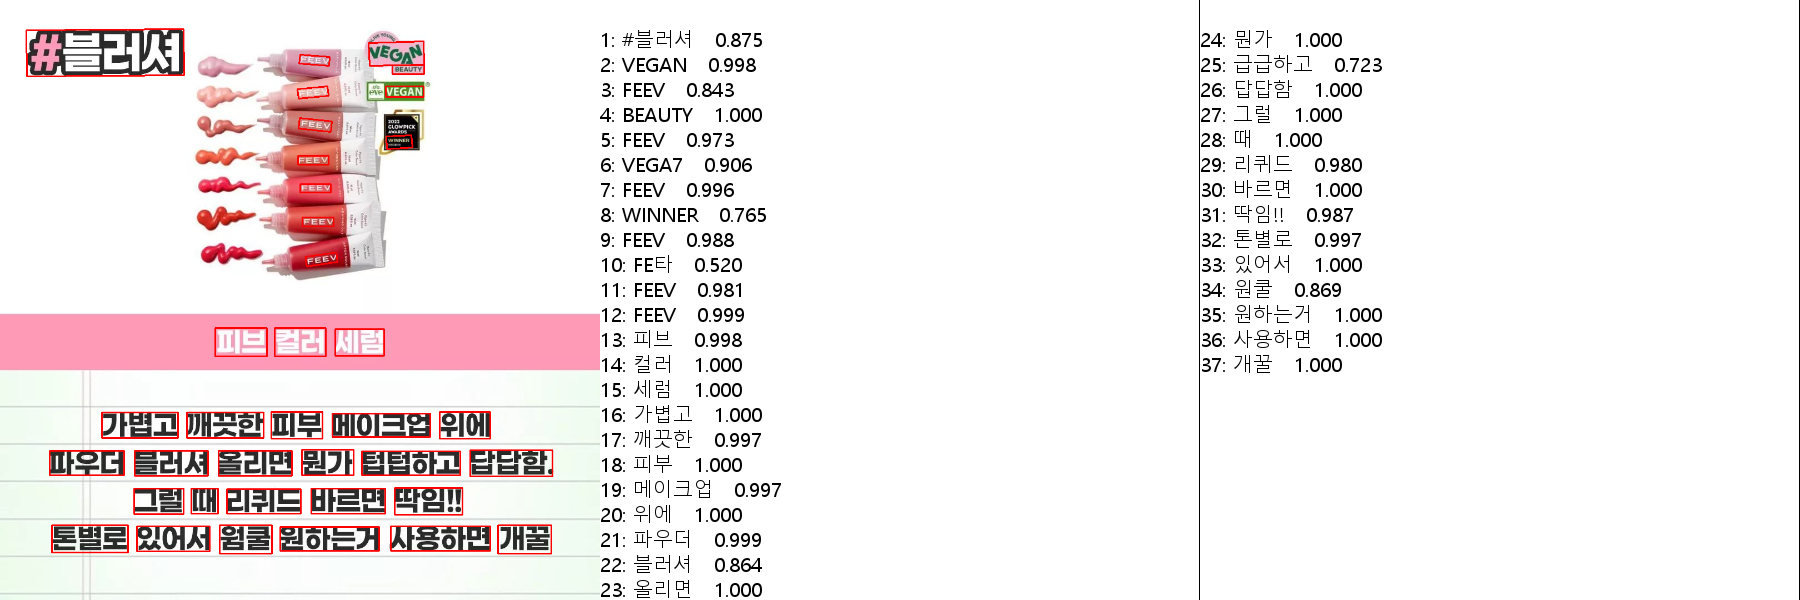

In [20]:
dir_path = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images'
img_path = dir_path + '/' + '457876620_1270198097683897_7748272549655420336_n.webp'

result = ocr.ocr(img_path, cls=True)

# for idx in range(len(result)):
#     res = result[idx]
#     for line in res:
#         print(line)

# draw result
result = result[0]
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(image, boxes, txts, scores, font_path='./fonts/malgun.ttf')
im_show = Image.fromarray(im_show)

print(' '.join(txts))
im_show

### ocr_text 추가

In [2]:
import pandas as pd
import shutil
import os
from paddleocr import PaddleOCR
from tqdm import tqdm

# OCR 엔진
ocr = PaddleOCR(use_angle_cls=True, lang='korean', show_log=False)

# 파일 경로
data = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/data.csv'    
final = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/final_data.csv'
backup = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/final_data_backup.csv'

initial = False

if os.path.exists(final):
    # 백업 파일
    shutil.copyfile(final, backup)
    final_df = pd.read_csv(final, encoding='utf-8', usecols=['brand', 'username', 'date', 'post_url', 'full_text', 'like', 'saved_imgs', 'ocr_text'])
    
else:
    initial = True
    shutil.copyfile(data, final)
    final_df = pd.read_csv(final, encoding='utf-8', usecols=['brand', 'username', 'date', 'post_url', 'full_text', 'like', 'saved_imgs'])
    final_df['ocr_text'] = pd.NA
    final_df.to_csv(final, index=False, encoding='utf-8')

# data.csv 에서 새로 생긴 데이터만 추출(최초에는 모두 ocr 을 돌려야 함)
if not initial:
    data_df = pd.read_csv(data, encoding='utf-8', usecols=['brand', 'username', 'date', 'post_url', 'full_text', 'like', 'saved_imgs'])
    new_data_df = data_df.merge(final_df, on=['brand', 'username', 'date', 'post_url', 'full_text', 'like', 'saved_imgs'], how='left', indicator=True)
    new_data_df = new_data_df[new_data_df['_merge'] == 'left_only'].drop(columns=['_merge'])

    # OCR 컬럼 추가
    new_data_df['ocr_text'] = pd.NA

else:
    new_data_df = final_df

dir_path = '/Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/'

# OCR 처리
for i, img_paths in tqdm(new_data_df['saved_imgs'].items(), total=len(new_data_df)):
    img_paths = eval(img_paths)  # 문자열을 리스트로 변환
    
    if pd.notna(new_data_df.at[i, 'ocr_text']):
        continue
    
    ocr_texts = []
    for img_path in img_paths:
        full_img_path = dir_path + img_path
        try:
            result = ocr.ocr(full_img_path, cls=True)
            txts = [line[1][0] for line in result[0]]
            scores = [line[1][1] for line in result[0]]
            ocr_texts.extend(txt for txt, score in zip(txts, scores) if score > 0.9)
        except Exception:
            print(f"{full_img_path} 내 text 없음")
    
    ocr_text = ' '.join(ocr_texts)
    new_data_df.at[i, 'ocr_text'] = ocr_text

# 데이터 합치기
if not initial:
    final_df = pd.read_csv(final, encoding='utf-8', usecols=['brand', 'username', 'date', 'post_url', 'full_text', 'like', 'saved_imgs', 'ocr_text'])
    final_df = pd.concat([final_df, new_data_df], ignore_index=True)
else:
    final_df = new_data_df

final_df.to_csv(final, index=False, encoding='utf-8')

  7%|▋         | 9/124 [03:23<45:33, 23.77s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457905816_919725939972236_7594414307320102704_n.jpg: 'NoneType' object is not iterable


 12%|█▏        | 15/124 [13:14<2:19:00, 76.52s/it] 

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457620156_1033847808060964_4498048434942984233_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457489455_893312129327432_4642541302593528213_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457379908_437626485970090_3791408968634189564_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457596903_1022217822564169_1864999256375537305_n.jpg: 'NoneType' object is not iterable


 13%|█▎        | 16/124 [13:28<1:44:26, 58.03s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457504461_1619109205322414_5759891498195257508_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458163125_516563324252909_4050947029373171945_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457655732_2248527325545813_6323766321923677609_n.jpg: 'NoneType' object is not iterable


 15%|█▌        | 19/124 [13:40<45:54, 26.23s/it]  

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457882399_1866380367106124_8900518399796308867_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458130223_1528706554714437_3211192626296277976_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458258977_1218103322719494_1082664372221817371_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457853173_1649526272495850_9133777647094558989_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458189101_775670334571156_4633230066876703952_n.jpg: 'NoneType' object is not iterable


 16%|█▌        | 20/124 [14:07<45:40, 26.35s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458205918_1995154327614041_4949982364863160945_n.jpg: 'NoneType' object is not iterable


 17%|█▋        | 21/124 [14:11<34:42, 20.22s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457867755_1687015972086107_6152033408081872251_n.jpg: 'NoneType' object is not iterable


 18%|█▊        | 22/124 [14:16<27:07, 15.95s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458179604_3644815329163990_1733549806519297587_n.jpg: 'NoneType' object is not iterable


 19%|█▊        | 23/124 [15:37<58:07, 34.53s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/454640793_845411701017860_4232149173015968582_n.jpg: 'NoneType' object is not iterable


 23%|██▎       | 29/124 [17:31<40:21, 25.48s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/396697013_18414077908060209_8154204072529703719_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/397452591_18414077956060209_4959890513205397789_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/397399554_18414077926060209_6134468439189782189_n.jpg: 'NoneType' object is not iterable


 27%|██▋       | 33/124 [19:05<43:00, 28.36s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/293101862_752393782476926_8274807638643420609_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/292583176_164046106205472_4749090431132900488_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/292833364_145610861464256_5181258596515664426_n.jpg: 'NoneType' object is not iterable


 27%|██▋       | 34/124 [19:10<31:40, 21.12s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/292938790_1171917373597705_6147903799942339420_n.jpg: 'NoneType' object is not iterable


 30%|██▉       | 37/124 [20:45<38:04, 26.26s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457379943_18285591628208569_4889151159610925766_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457457241_18285591601208569_8770948684222812076_n.jpg: 'NoneType' object is not iterable


 31%|███       | 38/124 [20:50<28:47, 20.09s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/453881775_18115127488381034_3182595254551814772_n.jpg: 'NoneType' object is not iterable


 35%|███▌      | 44/124 [23:05<34:13, 25.67s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/456460843_411495764811510_4748169658819609842_n.jpg: 'NoneType' object is not iterable


 37%|███▋      | 46/124 [23:11<19:25, 14.94s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/451396949_1001029751821287_7052532492849129274_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/454390691_3716063895325027_8114051162656322171_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/454510742_877038624272085_6868562492439524060_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/454401552_1010603866997321_3034964492849872991_n.jpg: 'NoneType' object is not iterable


 38%|███▊      | 47/124 [23:23<18:07, 14.12s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/454363863_1520217205596848_4294293552428968176_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/453438938_1237720257671861_5669489102363052194_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/453885424_852638209691751_8699471966400691904_n.jpg: 'NoneType' object is not iterable


 40%|███▉      | 49/124 [23:52<17:32, 14.03s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/305577778_1102710733767821_6476438546596331703_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/305668057_415322050586960_1727702196345525123_n.jpg: 'NoneType' object is not iterable


 40%|████      | 50/124 [24:01<15:42, 12.73s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/305655914_781635462959048_4002525981178128675_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/455350513_522096683492219_2918908351488745920_n.jpg: 'NoneType' object is not iterable


 41%|████      | 51/124 [24:08<13:23, 11.01s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/317655946_548293333787661_8668859674105812708_n.jpg: 'NoneType' object is not iterable


 43%|████▎     | 53/124 [24:35<15:05, 12.75s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458258983_1042177950803529_3086563164891794571_n.webp: 'NoneType' object is not iterable


 46%|████▌     | 57/124 [25:13<13:48, 12.36s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458186028_18014392856544425_3881861221275855642_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458149677_18014392895544425_7922158530764083869_n.jpg: 'NoneType' object is not iterable


 51%|█████     | 63/124 [27:15<16:05, 15.82s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458184231_1681479689317193_7528914385597314899_n.webp: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457866731_878817960244533_5867754676940222202_n.webp: 'NoneType' object is not iterable


 52%|█████▏    | 64/124 [27:24<14:17, 14.29s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457875274_491920877036285_1210603887908032883_n.webp: 'NoneType' object is not iterable


 52%|█████▏    | 65/124 [28:18<23:12, 23.61s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457383305_17895451251060267_753693417683572758_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457743012_17895451269060267_4818257544684756310_n.jpg: 'NoneType' object is not iterable


 56%|█████▌    | 69/124 [29:31<20:11, 22.03s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457134846_870563065009546_7884416234250764877_n.jpg: 'NoneType' object is not iterable


 60%|█████▉    | 74/124 [33:25<29:58, 35.98s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457147836_17898169203045764_746459294353917971_n.jpg: 'NoneType' object is not iterable


 62%|██████▏   | 77/124 [34:27<19:01, 24.28s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457732808_505816082395199_719638977084771093_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457168238_534654749130209_2612481258119229360_n.jpg: 'NoneType' object is not iterable


 63%|██████▎   | 78/124 [37:03<47:50, 62.41s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457259668_417951374084978_5854754440110446902_n.jpg: 'NoneType' object is not iterable


 64%|██████▎   | 79/124 [37:24<37:39, 50.22s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457263493_1489315765033791_7886977167555945975_n.jpg: 'NoneType' object is not iterable


 65%|██████▌   | 81/124 [38:39<31:46, 44.34s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457404818_494736343266331_8815599369927737036_n.jpg: 'NoneType' object is not iterable


 73%|███████▎  | 91/124 [40:44<06:14, 11.34s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457356713_353148297752221_8792095122185564720_n.jpg: 'NoneType' object is not iterable


 76%|███████▌  | 94/124 [40:59<04:14,  8.49s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457266492_387452037720620_58527560291380817_n.jpg: 'NoneType' object is not iterable


 78%|███████▊  | 97/124 [41:47<04:22,  9.73s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/345563534_1377155199742076_3096149143072433410_n.heic: 'NoneType' object is not iterable


 81%|████████  | 100/124 [42:02<02:35,  6.46s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/94571873_265934254575549_4123969844468257266_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458275029_1185830452677579_2061863380032430701_n.jpg: 'NoneType' object is not iterable


 88%|████████▊ | 109/124 [44:25<02:30, 10.04s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457370776_18457776616006770_8498533830060131695_n.jpg: 'NoneType' object is not iterable


 90%|█████████ | 112/124 [45:17<02:14, 11.17s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/456719483_1066619298517405_6959268892543485602_n.webp: 'NoneType' object is not iterable


 91%|█████████ | 113/124 [45:19<01:36,  8.74s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458231757_514266704888682_7165945374184519356_n.webp: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/91267268_268369314170406_6379581090918092821_n.jpg: 'NoneType' object is not iterable


 92%|█████████▏| 114/124 [45:20<01:06,  6.68s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/458211999_1073137557523782_8346221609830187446_n.webp: 'NoneType' object is not iterable


 93%|█████████▎| 115/124 [45:20<00:45,  5.02s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/457396916_1279233300173108_7243702184753357403_n.webp: 'NoneType' object is not iterable


 94%|█████████▎| 116/124 [45:33<00:56,  7.10s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/230063746_995807277887293_3264112615814324453_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/229696224_353947862931597_3118200882267062078_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/231489934_967407130491560_8568449464963488752_n.jpg: 'NoneType' object is not iterable


 94%|█████████▍| 117/124 [45:37<00:44,  6.33s/it]

Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/227619609_360096705767825_3754396319111941112_n.jpg: 'NoneType' object is not iterable
Error processing image /Users/baekkwanghyun/Desktop/Projects/5.Viral/results/images/454350034_18011193167544425_7058737505721603207_n.jpg: 'NoneType' object is not iterable


100%|██████████| 124/124 [47:01<00:00, 22.76s/it]
